In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=RuntimeWarning)

import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import re
from bs4 import BeautifulSoup
from termcolor import colored
nltk.download('wordnet')

from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU,Input
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# read the dataset
df=pd.read_json('/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json', lines=True)
# make a copy of the dataset
sarcasm_df = df.copy()

In [37]:
sarcasm_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [38]:
#Drop the article_link column as we are not using this in classification
del sarcasm_df['article_link']

In [39]:
#   Function
def unique(df):
 for col in df.columns:
  unique_values = df[col].explode().unique()
  typee = df[col].dtype
  if len(unique_values) > 50:
   print(f"{col} has {len(unique_values)} unique values")
  else:
    print(f"{col} contains: {', '.join(map(str, unique_values))}")

def missing(df):
  missing_count = df.isnull().sum()
  total_values = df.shape[0]
  missing_percentage = (missing_count / total_values) * 100
  missing_data_summary = pd.DataFrame({
      '\033[1mMissing Count\033[0m': missing_count,
      '\033[1mMissing Percentage\033[0m': missing_percentage
  })
  print(missing_data_summary)

def desc_cols(df):
  numeric_cols = df.columns[df.dtypes!='object']
  categorical_cols = df.columns[df.dtypes=='object']
  print("\033[1mNumber of Numerical Cols",len(numeric_cols),"\033[0m")
  print(list(numeric_cols))
  print('-'*85)
  print("\033[1mNumber of Catageroical Cols",len(categorical_cols),"\033[0m")
  print(list(categorical_cols))

In [40]:
sarcasm_df.shape

(28619, 2)

In [41]:
sarcasm_df.dtypes

is_sarcastic     int64
headline        object
dtype: object

In [42]:
desc_cols(sarcasm_df)

Number of Numerical Cols 1 
['is_sarcastic']
-------------------------------------------------------------------------------------
Number of Catageroical Cols 1 
['headline']


In [43]:
missing(sarcasm_df)

              Missing Count  Missing Percentage
is_sarcastic                      0                         0.0
headline                          0                         0.0


In [44]:
unique(sarcasm_df)

is_sarcastic contains: 1, 0
headline has 28503 unique values


In [45]:
sarcasm_df.duplicated().sum()

116

In [46]:
# Check for duplicate rows
duplicate_rows = sarcasm_df[sarcasm_df.duplicated()]

# Print duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)


Duplicate Rows:
       is_sarcastic                                           headline
1780              1                                      willow rented
3978              1              all y'all urged to go fuck yo' selves
4771              0                                     sunday roundup
4904              1   tammys of the world demand to be taken seriously
5092              0         the funniest tweets from parents this week
...             ...                                                ...
28235             1   magical gallery transforms dull objects into art
28246             1  candy purchase puts yet more money in raisinet...
28449             1                  congress raises killing age to 19
28456             1  rotating knife vortex closed pending safety in...
28595             1  man adds a few personalized tracks to standard...

[116 rows x 2 columns]


In [47]:
sarcasm_df=sarcasm_df.drop_duplicates()

In [48]:
sarcasm_df.duplicated().sum()

0

In [49]:
sarcasm_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [50]:
sarcasm_df.groupby('is_sarcastic').count().style.background_gradient(cmap = "autumn")

,headline
is_sarcastic,
0,14951
1,13552


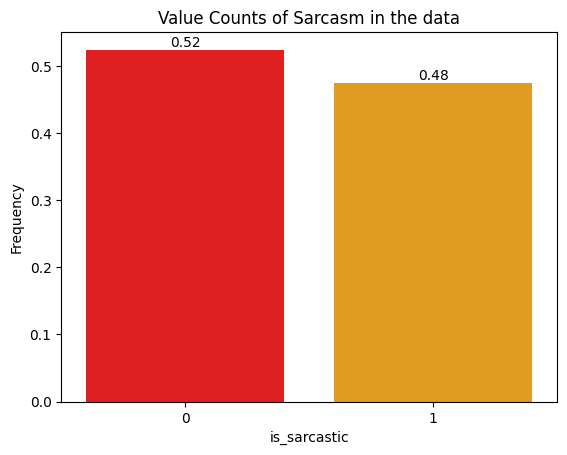

In [51]:
# Define colors for the bars
colors = ["red", "orange"]

normalized_value_counts = sarcasm_df['is_sarcastic'].value_counts(normalize=True)

# Create the bar plot
sns.barplot(x=normalized_value_counts.index, y=normalized_value_counts.values, palette=colors)

# Customize the plot
plt.xlabel('is_sarcastic')
plt.ylabel('Frequency')
plt.title('Value Counts of Sarcasm in the data')


for index, value in enumerate(normalized_value_counts.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


We can see that the dataset is balanced having almost equal representation of each class in the dataset.

**DATA PRE-PROCESSING**

In [52]:
def convert_to_lowercase(headline):
    return headline.lower()

def remove_punctuation(headline):
    return headline.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(headline):
    return ''.join(word for word in headline if not word.isdigit())

def strip_html(headline):
    soup = BeautifulSoup(headline, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(headline):
    return re.sub('\[[^]]*\]', '', headline)

def remove_urls(headline):
    return re.sub(r'http\S+', '', headline)

def remove_stopwords(headline):
    stop_words = set(stopwords.words('english'))
    punctuations = list(string.punctuation)
    stop_words.update(punctuations)
    return ' '.join(word for word in headline.split() if word not in stop_words)

def lemmatize_text(headline):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in headline.split())

In [53]:
def preprocess_text(sarcasm_df):
    sarcasm_df['headline'] = sarcasm_df['headline'].apply(convert_to_lowercase)
    print("\nCONVERTED TO LOWERCASE SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(strip_html)
    print("\nSTRIPPED HTML TAGS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(remove_between_square_brackets)
    print("\nREMOVED TEXT BETWEEN SQUARE BRACKETS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(remove_urls)
    print("\nREMOVED URLS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(remove_punctuation)
    print("\nREMOVED PUNCTUATION MARKS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(remove_numbers)
    print("\nREMOVED NUMBERS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(remove_stopwords)
    print("\nREMOVED STOPWORDS SUCCESSFULLY...")

    sarcasm_df['headline'] = sarcasm_df['headline'].apply(lemmatize_text)
    print("\nLEMMAZTIZED SUCCESSFULLY...")

    return sarcasm_df

In [54]:
sarcasm_df = preprocess_text(sarcasm_df)


CONVERTED TO LOWERCASE SUCCESSFULLY...


<ipython-input-52-cc0b128846b0>:11: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.




STRIPPED HTML TAGS SUCCESSFULLY...

REMOVED TEXT BETWEEN SQUARE BRACKETS SUCCESSFULLY...

REMOVED URLS SUCCESSFULLY...

REMOVED PUNCTUATION MARKS SUCCESSFULLY...

REMOVED NUMBERS SUCCESSFULLY...

REMOVED STOPWORDS SUCCESSFULLY...

LEMMAZTIZED SUCCESSFULLY...


In [55]:
sarcasm_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress falling short ge...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar getting work
4,1,mother come pretty close using word streaming ...


In [56]:
# Feature Engineering

# Creating new column headline_tokens to analyze the tokens and there frequency in headlines
sarcasm_df['headline_tokens'] = sarcasm_df['headline'].apply(lambda x: word_tokenize(x))

# Creating new column headline_length to analyze length of headline and find any outliers
sarcasm_df['headline_length'] = sarcasm_df['headline_tokens'].apply(lambda x: len(x))

In [57]:
sarcasm_df.head()

,is_sarcastic,headline,headline_tokens,headline_length
0,1,thirtysomething scientist unveil doomsday cloc...,"[thirtysomething, scientist, unveil, doomsday,...",7
1,0,dem rep totally nail congress falling short ge...,"[dem, rep, totally, nail, congress, falling, s...",10
2,0,eat veggie deliciously different recipe,"[eat, veggie, deliciously, different, recipe]",5
3,1,inclement weather prevents liar getting work,"[inclement, weather, prevents, liar, getting, ...",6
4,1,mother come pretty close using word streaming ...,"[mother, come, pretty, close, using, word, str...",8


**HEADLINE LENGTH DISTRIBUTION**


*   Look for outlier length of headline sentences
*   Usually the headlines shouldn't be more than 20-30 words

In [58]:
px.histogram(sarcasm_df, x ="headline_length", height= 700, color = 'is_sarcastic', title = "Headlines Length Distribution", marginal="box")

In [59]:
print("Mean of headline_length",np.mean(sarcasm_df['headline_length']))
print("Maximum length of headline", np.max(sarcasm_df['headline_length']))
print("Argmax", np.argmax(sarcasm_df['headline_length']))

Mean of headline_length 7.15391362312739
Maximum length of headline 106
Argmax 7288


In [60]:
# Longest headline_length
print(sarcasm_df['headline'].iloc[7288])

hot wheel ranked number one toy rolling ramp knocking domino send marble funnel dropping onto teetertotter yank string causing pulley system raise wooden block propelling series twine roller unwind spring launching tennis ball across room inching tire slope hit power switch activating table fan blow toy ship nail attached across kiddie pool popping water balloon fill cup weighing lever force basketball track nudging broomstick axis rotate allowing golf ball roll sideways coffee mug tumble row hardcover book handle catch hook attached lever cause wooden mallet slam serving spoon catapulting small ball cup attached ribbon lazy susan spin push battery incline plane tipping salt shaker season omelet


In [61]:
# Drop the outlier
sarcasm_df.drop(sarcasm_df[sarcasm_df['headline_length'] == 106].index, inplace = True)
sarcasm_df.reset_index(inplace=True, drop=True)

In [62]:
# Concatenate all token lists into a single list
all_tokens = [token for token_list in sarcasm_df['headline_tokens'] for token in token_list]

# Calculate the number of distinct tokens
num_distinct_tokens = len(set(all_tokens))

print("Size of Vocabulary after preprocessing:", num_distinct_tokens)

Size of Vocabulary after preprocessing: 25099


**WORD FREQUENCY ANALYSIS**

In [63]:
# top 10 words by its frequency
top_10 = Counter([token for sub_list in sarcasm_df['headline_tokens'] for token in sub_list])
top_10 = pd.DataFrame(top_10.most_common(10))
top_10 = top_10.iloc[0:,:]
top_10.columns = ['Common_words','count']
top_10.style.background_gradient(cmap='Purples')

,Common_words,count
0,trump,1794
1,new,1674
2,man,1497
3,woman,945
4,say,698
5,report,686
6,get,633
7,u,605
8,day,587
9,one,577


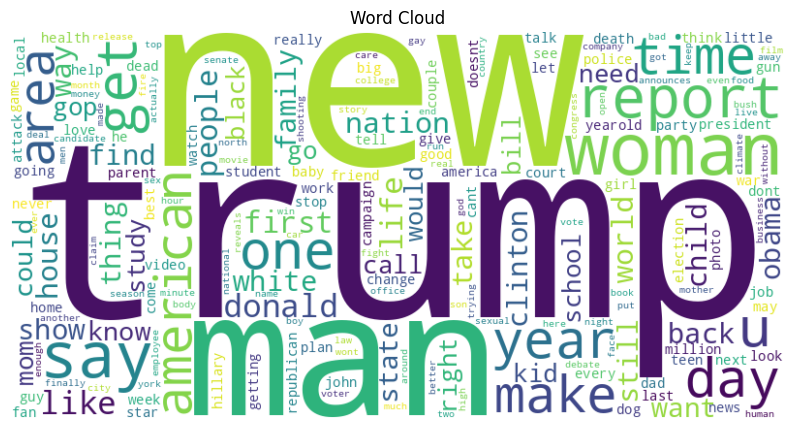

In [64]:
#  Word Frequency Analysis on entire dataset
all_words = [word for tokens in sarcasm_df['headline_tokens'] for word in tokens]
word_freq = nltk.FreqDist(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

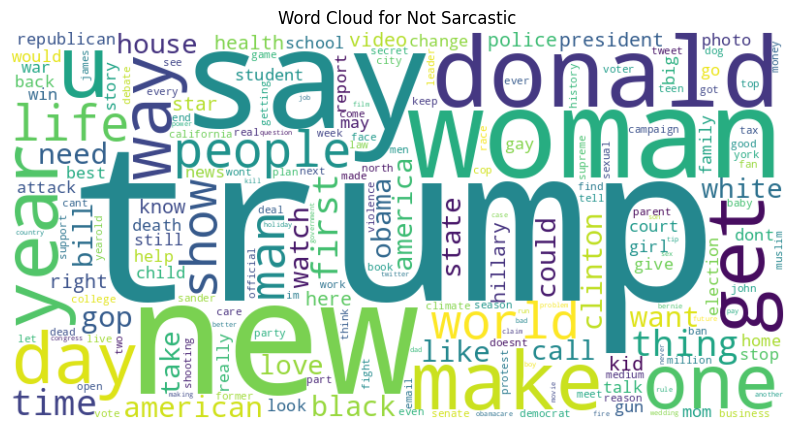

In [65]:
#  Word Frequency Analysis for not sarcastic
all_words = [word for tokens in sarcasm_df[sarcasm_df.is_sarcastic == 0].headline_tokens for word in tokens]
word_freq = nltk.FreqDist(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Not Sarcastic")
plt.show()

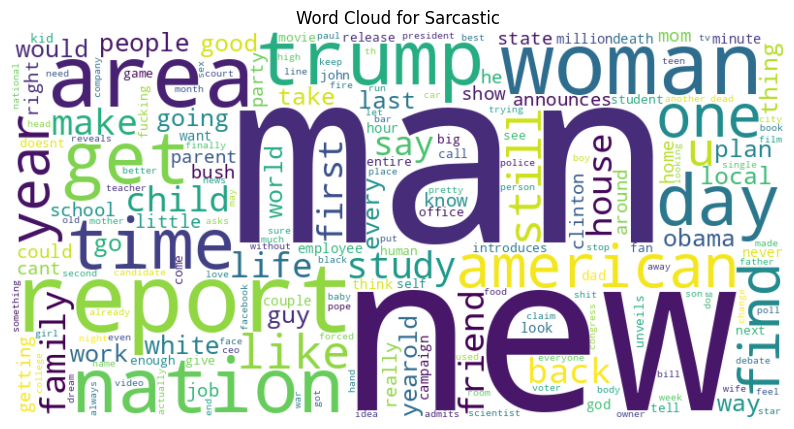

In [66]:
#  Word Frequency Analysis for sarcastic
all_words = [word for tokens in sarcasm_df[sarcasm_df.is_sarcastic == 1].headline_tokens for word in tokens]
word_freq = nltk.FreqDist(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Sarcastic")
plt.show()

In [67]:
#  Keyword Extraction (TF-IDF)
tfidf_vector = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vector.fit_transform(sarcasm_df['headline'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vector.get_feature_names_out())
tfidf_df['is_sarcastic'] = sarcasm_df['is_sarcastic']
top_keywords_sarcastic = tfidf_df[tfidf_df['is_sarcastic'] == 1].sum().sort_values(ascending=False)[:10]
top_keywords_non_sarcastic = tfidf_df[tfidf_df['is_sarcastic'] == 0].sum().sort_values(ascending=False)[:10]
print("\nTop Keywords in Sarcastic Headlines:")
print(top_keywords_sarcastic)
print("\nTop Keywords in Non-Sarcastic Headlines:")
print(top_keywords_non_sarcastic)


Top Keywords in Sarcastic Headlines:
is_sarcastic    13551.000000
man               454.374837
new               345.611948
report            226.775614
area              216.897413
woman             184.647335
nation            164.906772
american          127.993984
get               127.760384
time              125.776573
dtype: float64

Top Keywords in Non-Sarcastic Headlines:
trump     453.151168
new       228.497533
donald    190.241659
say       188.055393
woman     182.700016
make      135.741354
way       126.109124
get       125.801250
year      123.535162
day       116.601783
dtype: float64


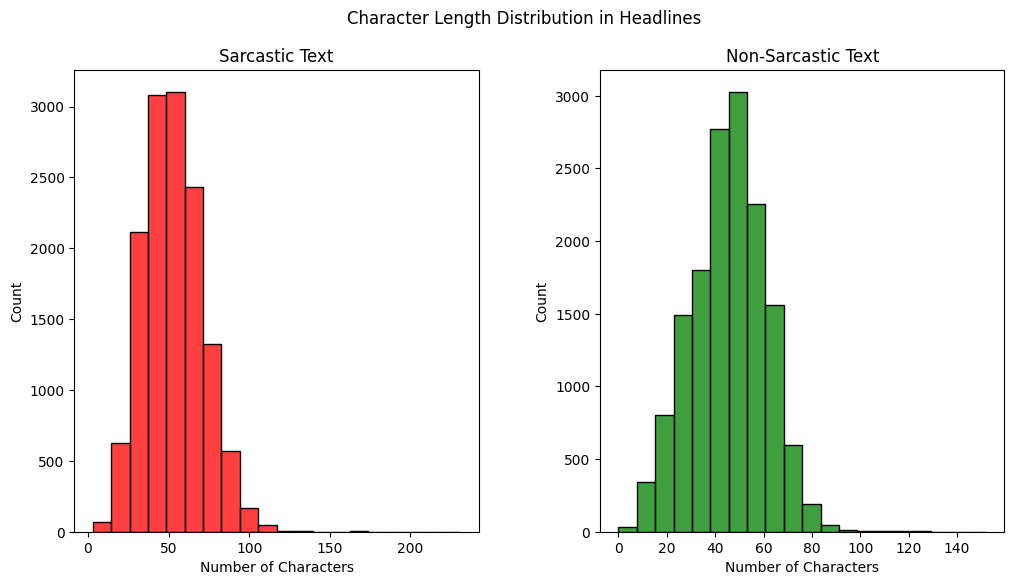

In [68]:
# Set up subplots with wider spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.3})

# Plot histograms for sarcastic text
sns.histplot(sarcasm_df[sarcasm_df['is_sarcastic'] == 1]['headline'].str.len(), bins=20, color='red', ax=ax1)
ax1.set_title('Sarcastic Text')
ax1.set_xlabel('Number of Characters')

# Plot histograms for non-sarcastic text
sns.histplot(sarcasm_df[sarcasm_df['is_sarcastic'] == 0]['headline'].str.len(), bins=20, color='green', ax=ax2)
ax2.set_title('Non-Sarcastic Text')
ax2.set_xlabel('Number of Characters')

fig.suptitle('Character Length Distribution in Headlines')
plt.show()

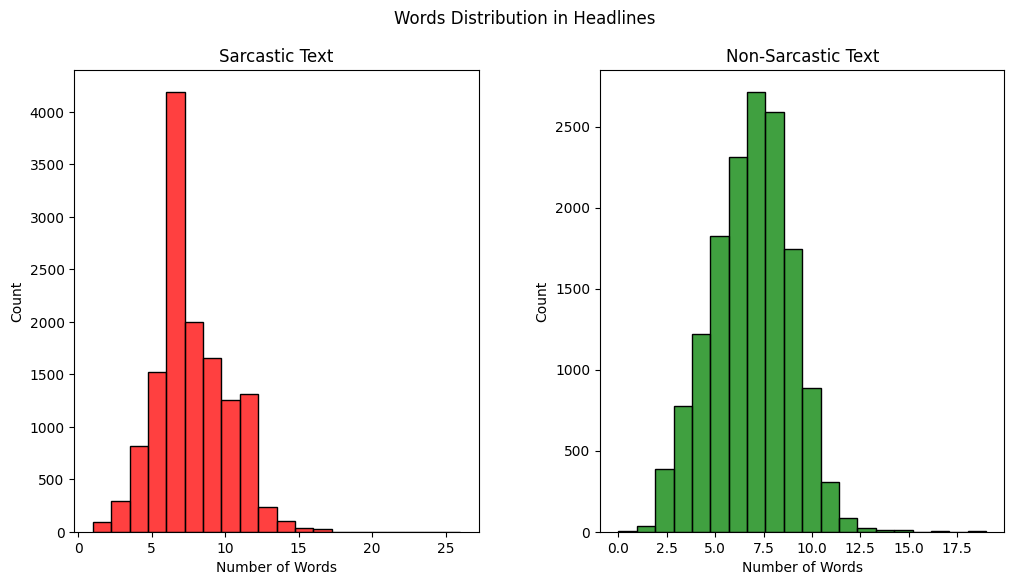

In [69]:
# Set up subplots with wider spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.3})

# Plot histograms for sarcastic text
sns.histplot(sarcasm_df[sarcasm_df['is_sarcastic'] == 1]['headline_length'], bins=20, color='red', ax=ax1)
ax1.set_title('Sarcastic Text')
ax1.set_xlabel('Number of Words')

# Plot histograms for non-sarcastic text
sns.histplot(sarcasm_df[sarcasm_df['is_sarcastic'] == 0]['headline_length'], bins=20, color='green', ax=ax2)
ax2.set_title('Non-Sarcastic Text')
ax2.set_xlabel('Number of Words')

fig.suptitle('Words Distribution in Headlines')
plt.show()

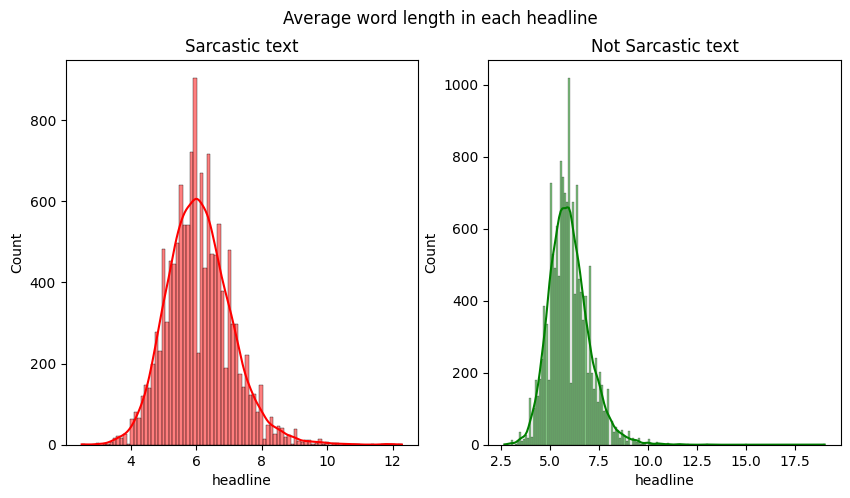

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Sarcastic text
word = sarcasm_df[sarcasm_df['is_sarcastic'] == 1]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red', kde=True)
ax1.set_title('Sarcastic text')

# Not Sarcastic text
word = sarcasm_df[sarcasm_df['is_sarcastic'] == 0]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green', kde=True)
ax2.set_title('Not Sarcastic text')

fig.suptitle('Average word length in each headline')
plt.show()

In [71]:
sarcasm_df.head(10)

,is_sarcastic,headline,headline_tokens,headline_length
0,1,thirtysomething scientist unveil doomsday cloc...,"[thirtysomething, scientist, unveil, doomsday,...",7
1,0,dem rep totally nail congress falling short ge...,"[dem, rep, totally, nail, congress, falling, s...",10
2,0,eat veggie deliciously different recipe,"[eat, veggie, deliciously, different, recipe]",5
3,1,inclement weather prevents liar getting work,"[inclement, weather, prevents, liar, getting, ...",6
4,1,mother come pretty close using word streaming ...,"[mother, come, pretty, close, using, word, str...",8
5,0,white inheritance,"[white, inheritance]",2
6,0,way file tax le stress,"[way, file, tax, le, stress]",5
7,1,richard bransons globalwarming donation nearly...,"[richard, bransons, globalwarming, donation, n...",10
8,1,shadow government getting large meet marriott ...,"[shadow, government, getting, large, meet, mar...",9
9,0,lot parent know scenario,"[lot, parent, know, scenario]",4


In [72]:
# Tokenize and pad sequences
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sarcasm_df['headline_tokens'])
sequences = tokenizer.texts_to_sequences(sarcasm_df['headline_tokens'])
max_length = max(len(seq) for seq in sequences)
X = sequence.pad_sequences(sequences, maxlen=max_length)

In [73]:
#maximum length of sequence
max_length

26

In [74]:
#Adjusting for the reserved 0 index
#The Embedding Layer includes an additional vector for "UNKNOWN" words or padded words (represented by 0s). This extra vector is initialized with zeros.
#Consequently, our vocabulary size increases by 1.
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

25100


In [75]:
# Early stopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(min_delta=0.001, mode="auto", verbose=1, monitor="val_acc", patience=3)

# List of callbacks
callbacks = [early_stopping]

In [76]:
#Split the data to train and test
x_train, x_test, y_train, y_test = train_test_split(X, sarcasm_df.is_sarcastic , test_size = 0.3 , random_state = 0)

**LSTM MODELS**

Without any pretrained word embeddings

In [77]:
EMBEDDING_DIM = 200
# Defining a neural network architecture
model_LSTM = Sequential()

# Adding an embedding layer to the LSTM model
model_LSTM.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, input_length=max_length))

# Adding Bidirectional LSTM layer with dropout
model_LSTM.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))

# Adding Bidirectional GRU layer with dropout
model_LSTM.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))

# Adding a Dense layer with sigmoid activation for binary classification
model_LSTM.add(Dense(1, activation='sigmoid'))

# Compiling the model_LSTM
model_LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [78]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 200)           5020000   
                                                                 
 bidirectional (Bidirection  (None, 26, 256)           336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5412641 (20.65 MB)
Trainable params: 5412641 (20.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
#feed the data to the model
history_LSTM = model_LSTM.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5, callbacks=callbacks)

Epoch 1/5
156/156 [==============================] - 139s 797ms/step - loss: 0.5188 - acc: 0.7276 - val_loss: 0.4244 - val_acc: 0.8015
Epoch 2/5
156/156 [==============================] - 118s 757ms/step - loss: 0.2538 - acc: 0.8984 - val_loss: 0.4599 - val_acc: 0.8058
Epoch 3/5
156/156 [==============================] - 120s 768ms/step - loss: 0.1261 - acc: 0.9542 - val_loss: 0.5638 - val_acc: 0.7891
Epoch 4/5
156/156 [==============================] - 120s 770ms/step - loss: 0.0766 - acc: 0.9736 - val_loss: 0.6734 - val_acc: 0.7851
Epoch 5/5
156/156 [==============================] - 152s 975ms/step - loss: 0.0505 - acc: 0.9830 - val_loss: 0.7455 - val_acc: 0.7851
Epoch 5: early stopping


In [80]:
print("Accuracy of the model on Training Data is - " , model_LSTM.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model_LSTM.evaluate(x_test,y_test)[1]*100)

624/624 [==============================] - 25s 39ms/step - loss: 0.0238 - acc: 0.9946
Accuracy of the model on Training Data is -  99.45867657661438
268/268 [==============================] - 11s 41ms/step - loss: 0.7455 - acc: 0.7851
Accuracy of the model on Testing Data is -  78.50543856620789


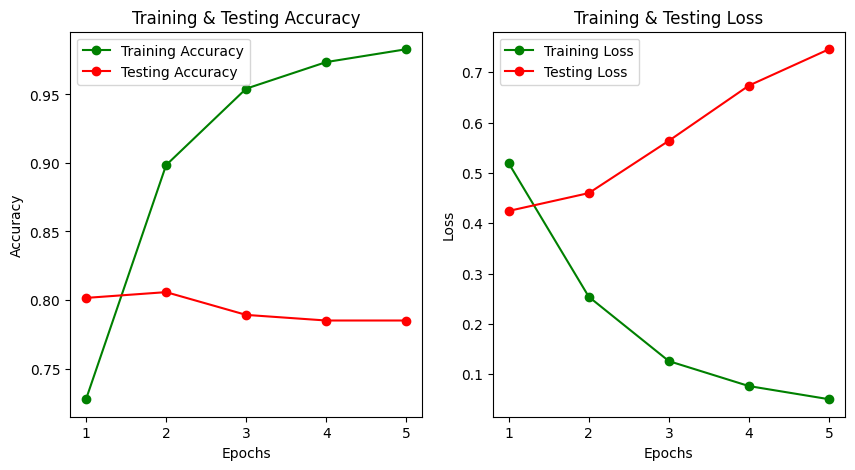

In [81]:
#Analysis of Bidirectional LSTM, GRU model with accuracy and loss
# Calculate No. of epochs

n_epochs=len(history_LSTM.history['loss'])
epochs = list(range(1,n_epochs+1))
fig , ax = plt.subplots(1,2)
train_acc = history_LSTM.history['acc']
train_loss = history_LSTM.history['loss']
val_acc = history_LSTM.history['val_acc']
val_loss = history_LSTM.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


The training accuracy of the model is exceptionally high at 99.42%, indicating that it performs very well on the training data. However, when evaluated on the testing data, the accuracy drops to 78.87%. This significant drop suggests that the model may be overfitting to the training data, meaning it is learning to memorize the training examples rather than generalize well to unseen data. One possible reason for this overfitting could be the high complexity of the model architecture, which may lead to excessive parameter tuning and capturing of noise in the training data.

To streamline the neural network architecture and improve generalization on test data, we'll simplify the model and reduce the number of parameters.

In [82]:
# Initialize a sequential model_LSTM2
model_LSTM2 = Sequential()

# Add an embedding layer to convert input sequences into dense vectors of size 200
model_LSTM2.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length))

# Add a LSTM layer with 64 units, dropout of 0.5 for input and recurrent connections, and return sequences
model_LSTM2.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

# Add a dense layer with 25 units and ReLU activation function
model_LSTM2.add(Dense(units=25, activation="relu"))

# Add dropout regularization with a rate of 0.5
model_LSTM2.add(Dropout(rate=0.5))

# Add a dense output layer with sigmoid activation for binary classification
model_LSTM2.add(Dense(units=1, activation="sigmoid"))

# Compile the model_LSTM2 with binary cross-entropy loss and Adam optimizer with learning rate 0.0045
model_LSTM2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0045), metrics=["acc"])

# Print the model_LSTM2 summary
model_LSTM2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 200)           5020000   
                                                                 
 lstm_1 (LSTM)               (None, 26, 64)            67840     
                                                                 
 dense_1 (Dense)             (None, 26, 25)            1625      
                                                                 
 dropout (Dropout)           (None, 26, 25)            0         
                                                                 
 dense_2 (Dense)             (None, 26, 1)             26        
                                                                 
Total params: 5089491 (19.41 MB)
Trainable params: 5089491 (19.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
#feed the data to the model
history_LSTM2 = model_LSTM2.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5)

Epoch 1/5
156/156 [==============================] - 43s 255ms/step - loss: 0.6590 - acc: 0.5763 - val_loss: 0.6346 - val_acc: 0.6010
Epoch 2/5
156/156 [==============================] - 40s 260ms/step - loss: 0.6043 - acc: 0.6171 - val_loss: 0.6387 - val_acc: 0.6014
Epoch 3/5
156/156 [==============================] - 38s 245ms/step - loss: 0.5750 - acc: 0.6305 - val_loss: 0.6669 - val_acc: 0.5999
Epoch 4/5
156/156 [==============================] - 38s 244ms/step - loss: 0.5585 - acc: 0.6371 - val_loss: 0.7102 - val_acc: 0.5988
Epoch 5/5
156/156 [==============================] - 39s 253ms/step - loss: 0.5489 - acc: 0.6404 - val_loss: 0.7761 - val_acc: 0.5980


In [84]:
print("Accuracy of the model on Training Data is - " , model_LSTM2.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model_LSTM2.evaluate(x_test,y_test)[1]*100)

624/624 [==============================] - 8s 12ms/step - loss: 0.5372 - acc: 0.6451
Accuracy of the model on Training Data is -  64.51035737991333
268/268 [==============================] - 3s 10ms/step - loss: 0.7761 - acc: 0.5980
Accuracy of the model on Testing Data is -  59.798699617385864


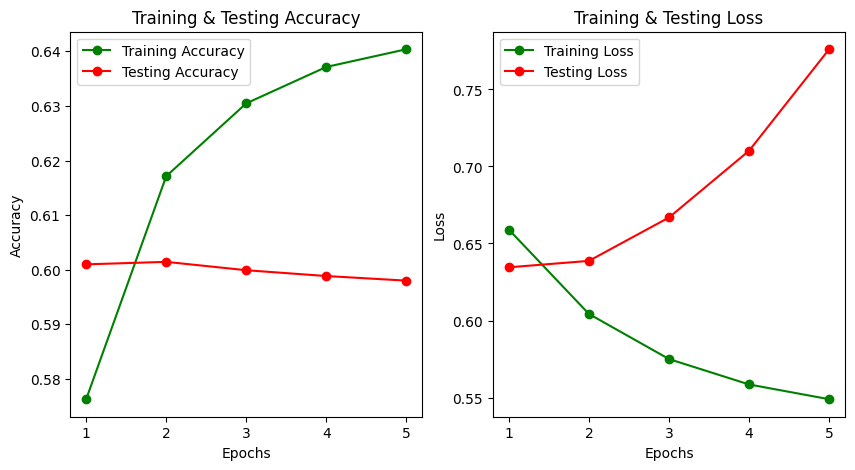

In [85]:
#Analysis of LSTM model with accuracy and loss
# Calculate No. of epochs

n_epochs=len(history_LSTM2.history['loss'])
epochs = list(range(1,n_epochs+1))
fig , ax = plt.subplots(1,2)
train_acc = history_LSTM2.history['acc']
train_loss = history_LSTM2.history['loss']
val_acc = history_LSTM2.history['val_acc']
val_loss = history_LSTM2.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

The simpler model with fewer layers is not overfitting as much as the more complex model. However, its performance is poor compared to the complex model. Specifically, the accuracy of the simpler model on the training data is 64.45%, while on the testing data, it is 59.80%.

Considering this, let's explore using pre-trained word embeddings such as Word2Vec and GloVe. These embeddings capture semantic relationships between words learned from large corpora. By using the embedding weights obtained from these pre-trained models, we aim to improve the model's performance and its ability to generalize better. This approach may leverage the contextual semantics embedded in the pre-trained word embeddings, potentially leading to better representation learning and higher accuracy on unseen data.

**WORD2VEC**

Word2Vec is a popular technique in natural language processing (NLP) used to learn distributed representations of words in a continuous vector space. The main idea behind Word2Vec is to represent words as dense, fixed-length vectors, often called word embeddings, in such a way that similar words have similar vector representations.

There are two main architectures for Word2Vec:

Continuous Bag of Words (CBOW): This architecture predicts the current word based on the context words within a fixed-size window around the current word.

Skip-gram: In this architecture, the model predicts the context words based on the current word.

Word2Vec is trained on large amounts of text data, where it learns to predict the target word given surrounding words  (in the case of CBOW) or predict the surrounding context words given a target word(in the case of Skip-gram). After training, the learned word embeddings capture semantic relationships between words, enabling applications such as word similarity, word analogies, and semantic understanding.

These word embeddings can then be used as features in various NLP tasks like sentiment analysis, named entity recognition, machine translation, and more. Word2Vec embeddings are often pre-trained on large corpora and then fine-tuned or used directly in downstream tasks, providing valuable representations of words that capture their contextual semantics.

In [86]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences = sarcasm_df['headline_tokens'] , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [87]:
def get_weight_matrix(model, vocab):
    # vocabulary size increases by 1 for unknown words
    vocab_size = len(vocab) + 1
    # initialize weight matrix with zeroes
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

In [88]:
# Obtaining embedding vectors from Word2Vec and using them as weights for a non-trainable Keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [89]:
# Defining a neural network architecture
model_word2vec = Sequential()

# Adding a non-trainable embedding layer initialized with pre-trained embedding vectors
model_word2vec.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_length, trainable=False))

# Adding Bidirectional LSTM layer with dropout
model_word2vec.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))

# Adding Bidirectional GRU layer with dropout
model_word2vec.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))

# Adding a Dense layer with sigmoid activation for binary classification
model_word2vec.add(Dense(1, activation='sigmoid'))

# Compiling the model_word2vec
model_word2vec.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

# Deleting embedding_vectors to conserve memory
del embedding_vectors

In [90]:
model_word2vec.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 200)           5020000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 26, 256)           336896    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5412641 (20.65 MB)
Trainable params: 392641 (1.50 MB)
Non-trainable params: 5020000 (19.15 MB)
_________________________________________________________________


In [91]:
#feed the data to the model
history_word2vec = model_word2vec.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5, callbacks=callbacks)

Epoch 1/5
156/156 [==============================] - 114s 645ms/step - loss: 0.6594 - acc: 0.5948 - val_loss: 0.6334 - val_acc: 0.6301
Epoch 2/5
156/156 [==============================] - 99s 633ms/step - loss: 0.6413 - acc: 0.6186 - val_loss: 0.6247 - val_acc: 0.6468
Epoch 3/5
156/156 [==============================] - 98s 626ms/step - loss: 0.6356 - acc: 0.6281 - val_loss: 0.6192 - val_acc: 0.6486
Epoch 4/5
156/156 [==============================] - 95s 613ms/step - loss: 0.6330 - acc: 0.6280 - val_loss: 0.6209 - val_acc: 0.6398
Epoch 5/5
156/156 [==============================] - 100s 642ms/step - loss: 0.6289 - acc: 0.6340 - val_loss: 0.6201 - val_acc: 0.6405


In [92]:
print("Accuracy of the model on Training Data is - " , model_word2vec.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model_word2vec.evaluate(x_test,y_test)[1]*100)

624/624 [==============================] - 23s 36ms/step - loss: 0.6217 - acc: 0.6371
Accuracy of the model on Training Data is -  63.7060821056366
268/268 [==============================] - 10s 38ms/step - loss: 0.6201 - acc: 0.6405
Accuracy of the model on Testing Data is -  64.05099034309387


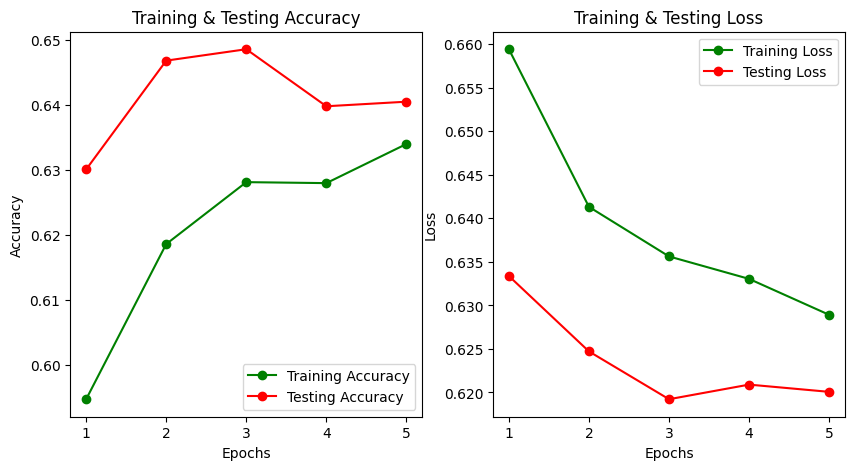

In [93]:
#Analysis of word2vec model with accuracy and loss
# Calculate No. of epochs

n_epochs=len(history_word2vec.history['loss'])
epochs = list(range(1,n_epochs+1))
fig , ax = plt.subplots(1,2)
train_acc = history_word2vec.history['acc']
train_loss = history_word2vec.history['loss']
val_acc = history_word2vec.history['val_acc']
val_loss = history_word2vec.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

268/268 [==============================] - 10s 32ms/step


,Not Sarcastic,Sarcastic
Not Sarcastic,2928,1592
Sarcastic,1482,2549


<Axes: >

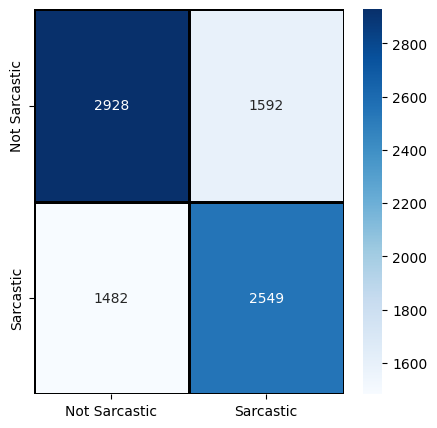

In [94]:
pred_probs = model_word2vec.predict(x_test)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
pred_labels = (pred_probs > 0.5).astype(int)

# Now you can use pred_labels for further analysis, such as computing metrics or plotting a confusion matrix

cm = confusion_matrix(y_test,pred_labels)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
display(cm)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

**GLOVE**

In [95]:
EMBEDDING_FILE = '/content/drive/MyDrive/glove.6B.100d.txt'

In [96]:
# function to extract word embeddings from GloVe file
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Create an embeddings_index dictionary by reading the GloVe file
# Each line of the file contains a word followed by its corresponding embedding vector
# The get_coefs function is applied to each line to extract the word and its embedding vector
# The resulting dictionary maps each word to its embedding vector
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))


In [97]:
# Create Word Embedding Matrix
embedding_matrix = np.zeros((vocab_size, 100))
for i in range(1,vocab_size):
	embedding_vector = embeddings_index.get(tokenizer.index_word[i])
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [98]:
# Defining Neural Network
model_glove = Sequential()

# Non-trainable embedding layer initialized with pre-trained GloVe embeddings
model_glove.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False))

# Adding Bidirectional LSTM layer with dropout
model_glove.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Adding a Dense layer with sigmoid activation for binary classification
model_glove.add(Dense(1, activation='sigmoid'))

# Compilation of model_glove
model_glove.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

In [99]:
model_glove.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 26, 100)           2510000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2744753 (10.47 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 2510000 (9.57 MB)
_________________________________________________________________


In [100]:
#fit the model to data
history_glove = model_glove.fit(x_train, y_train, batch_size = 128, validation_data = (x_test,y_test) , epochs = 5, callbacks=callbacks)

Epoch 1/5
156/156 [==============================] - 68s 394ms/step - loss: 0.5866 - acc: 0.6909 - val_loss: 0.5022 - val_acc: 0.7578
Epoch 2/5
156/156 [==============================] - 61s 392ms/step - loss: 0.5157 - acc: 0.7433 - val_loss: 0.5112 - val_acc: 0.7539
Epoch 3/5
156/156 [==============================] - 63s 402ms/step - loss: 0.4861 - acc: 0.7630 - val_loss: 0.4699 - val_acc: 0.7784
Epoch 4/5
156/156 [==============================] - 62s 396ms/step - loss: 0.4825 - acc: 0.7690 - val_loss: 0.4639 - val_acc: 0.7879
Epoch 5/5
156/156 [==============================] - 61s 393ms/step - loss: 0.4683 - acc: 0.7759 - val_loss: 0.4507 - val_acc: 0.8011


In [101]:
print("Accuracy of the model on Training Data is - " , model_glove.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model_glove.evaluate(x_test,y_test)[1]*100)

624/624 [==============================] - 14s 22ms/step - loss: 0.3784 - acc: 0.8306
Accuracy of the model on Training Data is -  83.06350708007812
268/268 [==============================] - 5s 19ms/step - loss: 0.4507 - acc: 0.8011
Accuracy of the model on Testing Data is -  80.10758757591248


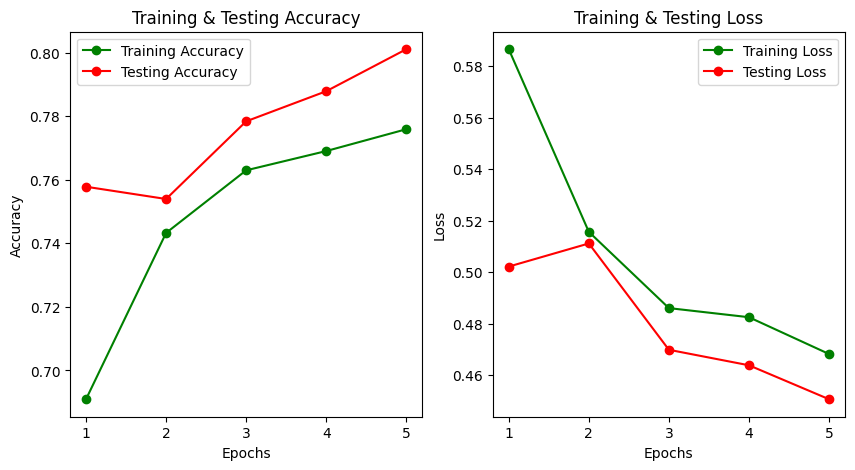

In [102]:
#Analysis of Glove model
# Calculate No. of epochs

n_epochs=len(history_glove.history['loss'])
epochs = list(range(1,n_epochs+1))
fig , ax = plt.subplots(1,2)
train_acc = history_glove.history['acc']
train_loss = history_glove.history['loss']
val_acc = history_glove.history['val_acc']
val_loss = history_glove.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

268/268 [==============================] - 5s 18ms/step


,Not Sarcastic,Sarcastic
Not Sarcastic,3790,730
Sarcastic,971,3060


<Axes: >

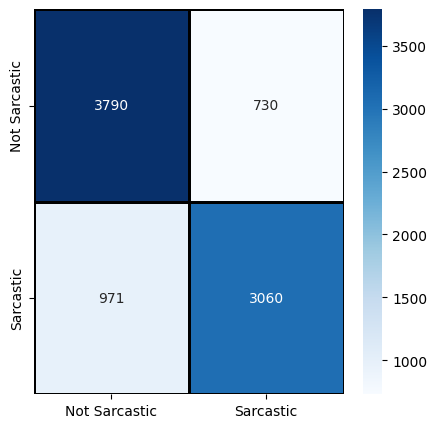

In [103]:
pred_probs = model_glove.predict(x_test)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
pred_labels = (pred_probs > 0.5).astype(int)

# Now you can use pred_labels for further analysis, such as computing metrics or plotting a confusion matrix

cm = confusion_matrix(y_test,pred_labels)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
display(cm)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [104]:
test_headline = ['Weather Report: Sunny Skies Expected Until Someone Makes Outdoor Plans']
sequences = tokenizer.texts_to_sequences(test_headline)
test_headline = sequence.pad_sequences(sequences, maxlen=max_length, dtype='int32', value=0)

sentiment = model_glove.predict(test_headline)
pred_labels = (sentiment > 0.5).astype(int)
if(pred_labels == 0):
    print("Non-sarcastic statement")
elif (pred_labels == 1):
    print("Sarcastic statement")

1/1 [==============================] - 0s 29ms/step
Sarcastic statement


In [105]:
test_headline = ['Cloudy Skies Expected Until tomorrow']
sequences = tokenizer.texts_to_sequences(test_headline)
test_headline = sequence.pad_sequences(sequences, maxlen=max_length, dtype='int32', value=0)

sentiment = model_glove.predict(test_headline)
pred_labels = (sentiment > 0.5).astype(int)
if(pred_labels == 0):
    print("Non-sarcastic statement")
elif (pred_labels == 1):
    print("Sarcastic statement")

1/1 [==============================] - 0s 25ms/step
Non-sarcastic statement


GloVe tends to perform better on tasks like binary classification for several reasons:

Global Context: GloVe embeddings are trained on global word co-occurrence statistics across the entire corpus, whereas Word2Vec focuses on local context (i.e., nearby words in a sentence). This global context captured by GloVe embeddings can provide more comprehensive semantic information, which can be beneficial for classification tasks.

Pre-trained Embeddings: GloVe embeddings are often pre-trained on large corpora, such as Wikipedia or Common Crawl, capturing a wide range of linguistic patterns and semantics. These pre-trained embeddings can encode richer semantic information compared to Word2Vec embeddings trained on smaller datasets or specific domains.

Embedding Quality: GloVe embeddings are known to capture linear relationships between words more effectively than Word2Vec embeddings. This property can be advantageous for tasks like binary classification, where understanding semantic relationships between words is crucial.

Dimensionality: GloVe embeddings often come in higher dimensions compared to Word2Vec embeddings, which can potentially capture more nuanced semantic information. While higher dimensions may lead to increased computational complexity, they can also provide richer representations, especially for complex classification tasks.

Overall, while both Word2Vec and GloVe are effective techniques for generating word embeddings, GloVe's focus on global word co-occurrence statistics and its pre-trained embeddings often make it a preferred choice for tasks like binary classification, where capturing nuanced semantic relationships is essential.

**MODELS PERFOMANCE COMPARISION**

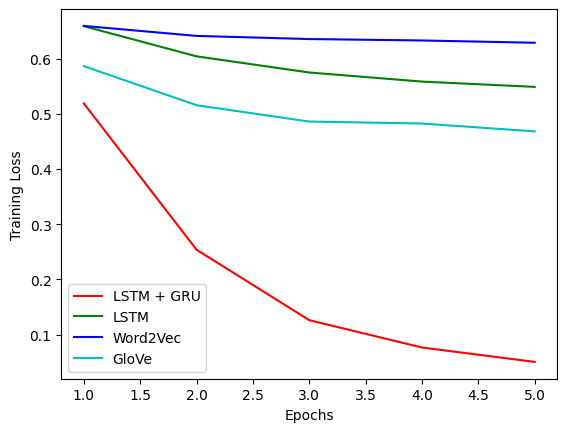

In [106]:
# Plotting Training Loss
epochs =[1, 2, 3, 4, 5]

plt.plot(epochs, history_LSTM.history['loss'], 'r', label='LSTM + GRU')
plt.plot(epochs, history_LSTM2.history['loss'], 'g', label='LSTM')
plt.plot(epochs, history_word2vec.history['loss'], 'b', label='Word2Vec')
plt.plot(epochs, history_glove.history['loss'], 'c', label='GloVe')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

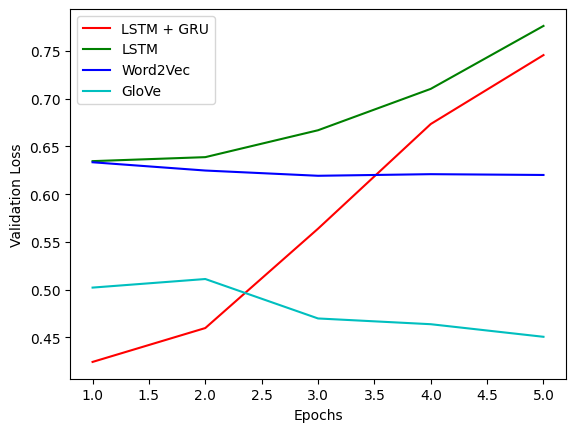

In [107]:
# Plotting Validation Loss
plt.plot(epochs, history_LSTM.history['val_loss'], 'r', label='LSTM + GRU')
plt.plot(epochs, history_LSTM2.history['val_loss'], 'g', label='LSTM')
plt.plot(epochs, history_word2vec.history['val_loss'], 'b', label='Word2Vec')
plt.plot(epochs, history_glove.history['val_loss'], 'c', label='GloVe')

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

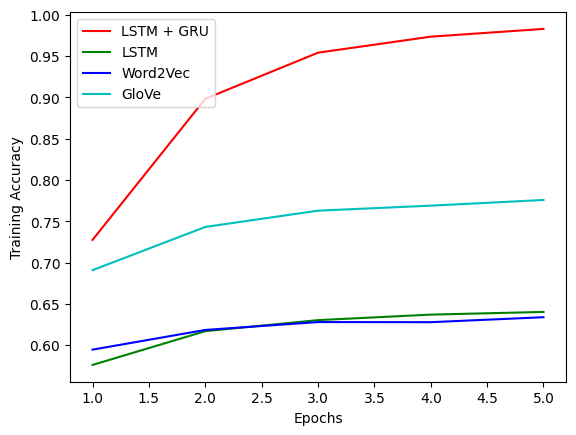

In [108]:
# Plotting Training Accuracy
plt.plot(epochs, history_LSTM.history['acc'], 'r', label='LSTM + GRU')
plt.plot(epochs, history_LSTM2.history['acc'], 'g', label='LSTM')
plt.plot(epochs, history_word2vec.history['acc'], 'b', label='Word2Vec')
plt.plot(epochs, history_glove.history['acc'], 'c', label='GloVe')

plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

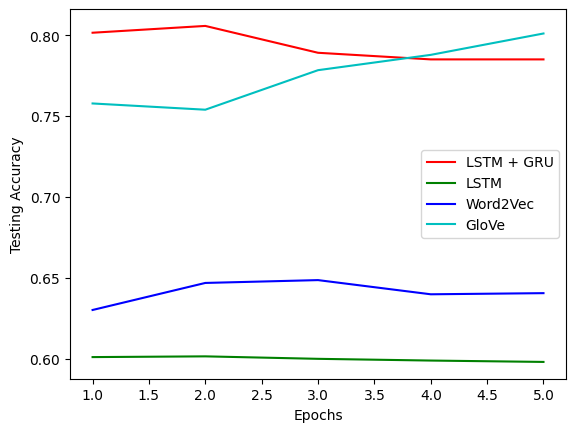

In [109]:
# Plotting Testing Accuracy
plt.plot(epochs, history_LSTM.history['val_acc'], 'r', label='LSTM + GRU')
plt.plot(epochs, history_LSTM2.history['val_acc'], 'g', label='LSTM')
plt.plot(epochs, history_word2vec.history['val_acc'], 'b', label='Word2Vec')
plt.plot(epochs, history_glove.history['val_acc'], 'c', label='GloVe')

plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.show()